<img src="https://i2.wp.com/www.ai-claudio.com/wp-content/uploads/2017/05/keras-tensorflow-logo.jpg?resize=500%2C201"/>

## Import modules 


In [13]:
import numpy as np
np.random.seed(73218)  # for reproducibility
import h5py
from keras.models import Sequential
from keras.optimizers import Adam
from keras.initializers import TruncatedNormal
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.callbacks import ReduceLROnPlateau

from sklearn.metrics import roc_curve, auc

import matplotlib.pyplot as plt

## Keras Model Parameters

In [18]:
lr_init     = 1.e-3    # Initial learning rate  
batch_size  = 128       # Training batch size
train_size  = 65536*2     # Training size
valid_size  = 32768     # Validation size
test_size   = 32768     # Test size
epochs      = 12       # Number of epochs
doGPU       = False    # Use GPU

In [19]:
# if doGPU:
#     import tensorflow as tf
#     from keras.backend.tensorflow_backend import set_session
#     config = tf.ConfigProto()
#     config.gpu_options.allow_growth=True
#     set_session(tf.Session(config=config))

## Load Image Data
### Two classes of particles: electrons and photons 
### Images from 32x32 matrices of energies in each calorimeter cell (one cell = one pixel) 

In [20]:
img_rows, img_cols, nb_channels = 32, 32, 2        
input_dir = 'data'
decays = ['SinglePhotonPt50_IMGCROPS_n249k_RHv1', 'SingleElectronPt50_IMGCROPS_n249k_RHv1']

def load_data(decays, start, stop):
    global input_dir
    dsets = [h5py.File('%s/%s.hdf5'%(input_dir,decay)) for decay in decays]
    X = np.concatenate([dset['/X'][start:stop] for dset in dsets])
    y = np.concatenate([dset['/y'][start:stop] for dset in dsets])
    assert len(X) == len(y)
    return X, y

## Configure Training/Validation/Test Sets

In [21]:
# Set range of training set
train_start, train_stop = 0, train_size
assert train_stop > train_start
assert (len(decays)*train_size) % batch_size == 0
X_train, y_train = load_data(decays,train_start,train_stop)

# Set range of validation set
valid_start, valid_stop = 160000, 160000+valid_size
assert valid_stop  >  valid_start
assert valid_start >= train_stop
X_valid, y_valid = load_data(decays,valid_start,valid_stop)

# Set range of test set
test_start, test_stop = 204800, 204800+test_size
assert test_stop  >  test_start
assert test_start >= valid_stop
X_test, y_test = load_data(decays,test_start,test_stop)

samples_requested = len(decays) * (train_size + valid_size + test_size)
samples_available = len(y_train) + len(y_valid) + len(y_test)
assert samples_requested == samples_available

In [22]:
X_test.shape, X_train.shape, X_valid.shape

((65536, 32, 32, 2), (262144, 32, 32, 2), (65536, 32, 32, 2))

## Plot  sample of training images

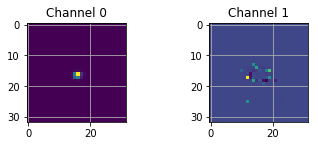

In [23]:
plt.figure(1)

plt.subplot(221)
plt.imshow(X_train[1,:,:,0])
plt.title("Channel 0")  # Energy
plt.grid(True)

plt.subplot(222)
plt.imshow(X_train[1,:,:,1])
plt.title("Channel 1")  # Time
plt.grid(True)


plt.show()

## Define CNN Model

In [24]:
### Define CNN Model ###

model = Sequential()
model.add(Conv2D(16, activation='relu', kernel_size=3, padding='same', kernel_initializer='TruncatedNormal', input_shape=(img_rows, img_cols, nb_channels)))
model.add(Conv2D(16, activation='relu', kernel_size=3, padding='same', kernel_initializer='TruncatedNormal'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(8, activation='relu', kernel_size=3, padding='same', kernel_initializer='TruncatedNormal'))
model.add(Conv2D(8, activation='relu', kernel_size=3, padding='same', kernel_initializer='TruncatedNormal'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=lr_init), metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 32, 32, 16)        304       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 16)        2320      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 16, 16, 8)         1160      
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 16, 8)         584       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 8, 8, 8)           0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 512)               0         
__________

### Train the Model

In [25]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1.e-6)
history=model.fit(X_train, y_train,\
        batch_size=batch_size,\
        epochs=epochs,\
        validation_data=(X_valid, y_valid),\
        callbacks=[reduce_lr],\
        verbose=1, shuffle=True)

Train on 262144 samples, validate on 65536 samples
Epoch 1/12
262144/262144 [==============================] - 141s 538us/step - loss: 0.6362 - acc: 0.6390 - val_loss: 0.6015 - val_acc: 0.6905
Epoch 2/12
262144/262144 [==============================] - 140s 534us/step - loss: 0.5895 - acc: 0.6966 - val_loss: 0.5934 - val_acc: 0.6955
Epoch 3/12
262144/262144 [==============================] - 140s 535us/step - loss: 0.5789 - acc: 0.7063 - val_loss: 0.5664 - val_acc: 0.7155
Epoch 4/12
262144/262144 [==============================] - 140s 534us/step - loss: 0.5696 - acc: 0.7125 - val_loss: 0.5748 - val_acc: 0.7045
Epoch 5/12
262144/262144 [==============================] - 139s 532us/step - loss: 0.5645 - acc: 0.7161 - val_loss: 0.5583 - val_acc: 0.7207
Epoch 6/12
262144/262144 [==============================] - 140s 533us/step - loss: 0.5605 - acc: 0.7190 - val_loss: 0.5514 - val_acc: 0.7256
Epoch 7/12
262144/262144 [==============================] - 139s 531us/step - loss: 0.5576 - acc:

### Evaluate The Model

In [26]:
# Evaluate on validation set
score = model.evaluate(X_valid, y_valid, verbose=1)
print('\nValidation loss / accuracy: %0.4f / %0.4f'%(score[0], score[1]))
y_pred = model.predict(X_valid)
fpr, tpr, _ = roc_curve(y_valid, y_pred)
roc_auc = auc(fpr, tpr)
print('Validation ROC AUC:', roc_auc)

# Evaluate on test set
score = model.evaluate(X_test, y_test, verbose=1)
print('\nTest loss / accuracy: %0.4f / %0.4f'%(score[0], score[1]))
y_pred = model.predict(X_test)
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print('Test ROC AUC:', roc_auc)

65536/65536 [==============================] - 10s 148us/step

Validation loss / accuracy: 0.5400 / 0.7329
Validation ROC AUC: 0.8031233372166753
65536/65536 [==============================] - 10s 147us/step

Test loss / accuracy: 0.5452 / 0.7304
Test ROC AUC: 0.7979779532179236


No handles with labels found to put in legend.


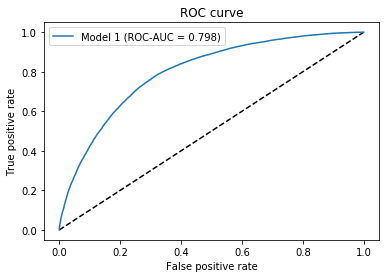

In [27]:
plt.plot([0, 1], [0, 1], 'k--')
plt.legend(loc=2, prop={'size': 15})
plt.plot(fpr, tpr, label='Model 1 (ROC-AUC = {:.3f})'.format(roc_auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()